In [1]:
import tensorflow as tf
import numpy as np
from PIL import Image
from keras.applications.vgg16 import VGG16
from keras import backend as K

from scipy.misc import imsave
from scipy.optimize import fmin_l_bfgs_b
import time

Using TensorFlow backend.


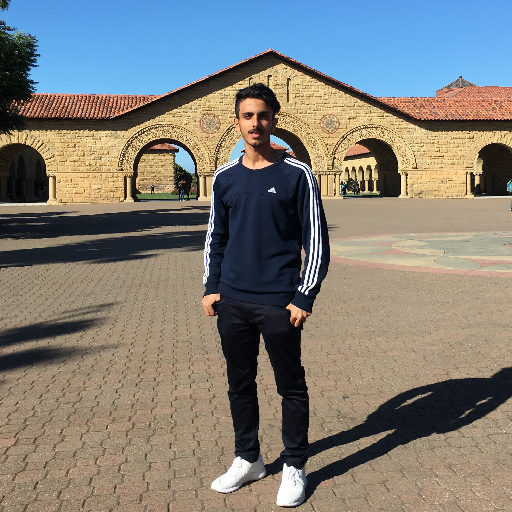

In [2]:
height = 512
width = 512
content_image_path = "images/IMG_2335.JPG"
content_image = Image.open(content_image_path)
content_image = content_image.resize((height,width))
content_image

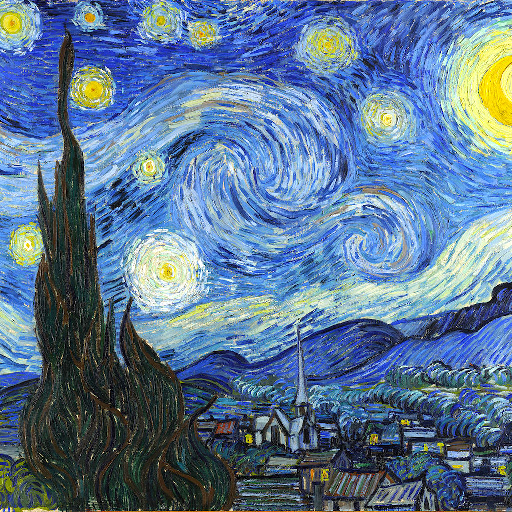

In [3]:
height = 512
width = 512
style_image_path = "images/style/starry_night.jpg"
style_image = Image.open(style_image_path)
style_image = style_image.resize((height,width))
style_image

In [4]:
content_array = np.asarray(content_image, np.float32)
#content_array = np.expand_dims(content_array, axis=0)
print(content_array.shape)

style_array = np.asarray(style_image, np.float32)
#style_array = np.expand_dims(style_array, axis=0)
print(content_array.shape)

(512, 512, 3)
(512, 512, 3)


In [5]:
#content_array = tf.image.per_image_standardization(content_array)
#print(content_array)
content_array = np.expand_dims(content_array, axis=0)
content_array[:, :, :, 0] -= 103.939
content_array[:, :, :, 1] -= 116.779
content_array[:, :, :, 2] -= 123.68
content_array = content_array[:, :, :, ::-1]


#style_array = tf.image.per_image_standardization(style_array)
#print(style_array)
style_array = np.expand_dims(style_array, axis=0)
style_array[:, :, :, 0] -= 103.939
style_array[:, :, :, 1] -= 116.779
style_array[:, :, :, 2] -= 123.68
style_array = style_array[:, :, :, ::-1]


content_image = K.variable(content_array)
style_image = K.variable(style_array)
combination_image = K.placeholder((content_array.shape[0], content_array.shape[1], content_array.shape[2], content_array.shape[3]))
input_tensor = K.concatenate([content_array, style_array, combination_image], axis=0)

#content_image = tf.Variable(content_array)
#style_image = tf.Variable(style_array)
#combination_image = tf.placeholder(tf.float32, shape=(content_array.shape[0], content_array.shape[1], content_array.shape[2], content_array.shape[3]))
#input_tensor = tf.concat([content_array, style_array, combination_image], axis=0)

In [6]:
model = VGG16(input_tensor=input_tensor, weights='imagenet', include_top=False)

In [7]:
layers = dict([(layer.name, layer.output) for layer in model.layers])
layers

{'block1_conv1': <tf.Tensor 'block1_conv1/Relu:0' shape=(3, 512, 512, 64) dtype=float32>,
 'block1_conv2': <tf.Tensor 'block1_conv2/Relu:0' shape=(3, 512, 512, 64) dtype=float32>,
 'block1_pool': <tf.Tensor 'block1_pool/MaxPool:0' shape=(3, 256, 256, 64) dtype=float32>,
 'block2_conv1': <tf.Tensor 'block2_conv1/Relu:0' shape=(3, 256, 256, 128) dtype=float32>,
 'block2_conv2': <tf.Tensor 'block2_conv2/Relu:0' shape=(3, 256, 256, 128) dtype=float32>,
 'block2_pool': <tf.Tensor 'block2_pool/MaxPool:0' shape=(3, 128, 128, 128) dtype=float32>,
 'block3_conv1': <tf.Tensor 'block3_conv1/Relu:0' shape=(3, 128, 128, 256) dtype=float32>,
 'block3_conv2': <tf.Tensor 'block3_conv2/Relu:0' shape=(3, 128, 128, 256) dtype=float32>,
 'block3_conv3': <tf.Tensor 'block3_conv3/Relu:0' shape=(3, 128, 128, 256) dtype=float32>,
 'block3_pool': <tf.Tensor 'block3_pool/MaxPool:0' shape=(3, 64, 64, 256) dtype=float32>,
 'block4_conv1': <tf.Tensor 'block4_conv1/Relu:0' shape=(3, 64, 64, 512) dtype=float32>,
 'b

In [8]:
content_weight = 0.025
style_weight = 5.0
total_variation_weight = 1.0


In [9]:
def content_loss(content_image, combination_image):
    return K.sum(K.square(content_image - combination_image))

In [10]:
total_loss = K.variable(0.)
layer_features = layers['block4_conv1']
content_image_features = layer_features[0,:, :, :]
combination_image_features = layer_features[2,:, :, :]
print("block4_conv2 layer: {}\ncontent_image_features: {}\ncombination_image_features: {}".format(layer_features, content_image_features, combination_image_features))

total_loss += content_weight * content_loss(content_image_features, combination_image_features)

block4_conv2 layer: Tensor("block4_conv1/Relu:0", shape=(3, 64, 64, 512), dtype=float32)
content_image_features: Tensor("strided_slice:0", shape=(64, 64, 512), dtype=float32)
combination_image_features: Tensor("strided_slice_1:0", shape=(64, 64, 512), dtype=float32)


In [11]:
def gram_matrix(x):
    features = K.batch_flatten(K.permute_dimensions(x, (2,0,1)))
    gram = K.dot(features, K.transpose(features))
    return gram

In [12]:
def style_loss(style_image, combination_image):
    S = gram_matrix(style_image)
    C = gram_matrix(combination_image)
    channels = 3
    size = height * width
    return K.sum(K.square(S - C)/(4. * (channels ** 2) * (size ** 2)))

feature_layers = ['block1_conv1', 'block2_conv1','block3_conv1', 'block4_conv1', 'block5_conv1']
for layer_name in feature_layers:
    layer_features = layers[layer_name]
    style_image_features = layer_features[1,:,:,:]
    combination_image_features = layer_features[2,:, :, :]
    s_l = style_loss(style_image_features, combination_image_features)
    total_loss += (style_weight / len(feature_layers)) * s_l

In [13]:
def total_variation_loss(x):
    a = K.square(x[:, :height-1, :width-1, :] - x[:, 1:, :width-1, :])
    b = K.square(x[:, :height-1, :width-1, :] - x[:, :height-1, 1:, :])
    return K.sum(K.pow(a + b, 1.25))

total_loss += total_variation_weight * total_variation_loss(combination_image)


In [14]:
grad = K.gradients(total_loss, combination_image)
print(grad)

[<tf.Tensor 'gradients/AddN_15:0' shape=(1, 512, 512, 3) dtype=float32>]


In [15]:
outputs = [total_loss]
outputs += grad
f_outputs = K.function([combination_image], outputs)

def eval_loss_and_grads(x):
    x = x.reshape((1, height, width, 3))
    outs = f_outputs([x])
    loss_value = outs[0]
    grad_values = outs[1].flatten().astype('float64')
    return loss_value, grad_values

class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

evaluator = Evaluator()

In [16]:
x = np.random.uniform(0, 255, size=(1, height, width, 3)) - 128

iterations = 30

for i in range(iterations):
    print("iteration {}/{}".format(i+1, iterations))
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(), fprime=evaluator.grads, maxfun=20)
    print('Current loss value:', min_val)

iteration 1/30
Current loss value: 2.82189e+10
iteration 2/30
Current loss value: 1.64165e+10
iteration 3/30
Current loss value: 1.34671e+10
iteration 4/30
Current loss value: 1.21767e+10
iteration 5/30
Current loss value: 1.14452e+10
iteration 6/30
Current loss value: 1.09843e+10
iteration 7/30
Current loss value: 1.06616e+10
iteration 8/30
Current loss value: 1.04125e+10
iteration 9/30
Current loss value: 1.02417e+10
iteration 10/30
Current loss value: 1.00632e+10
iteration 11/30
Current loss value: 9.92808e+09
iteration 12/30
Current loss value: 9.81602e+09
iteration 13/30
Current loss value: 9.69709e+09
iteration 14/30
Current loss value: 9.58365e+09
iteration 15/30
Current loss value: 9.50454e+09
iteration 16/30
Current loss value: 9.41493e+09
iteration 17/30
Current loss value: 9.34325e+09
iteration 18/30
Current loss value: 9.26694e+09
iteration 19/30
Current loss value: 9.20283e+09
iteration 20/30
Current loss value: 9.14775e+09
iteration 21/30
Current loss value: 9.09652e+09
i

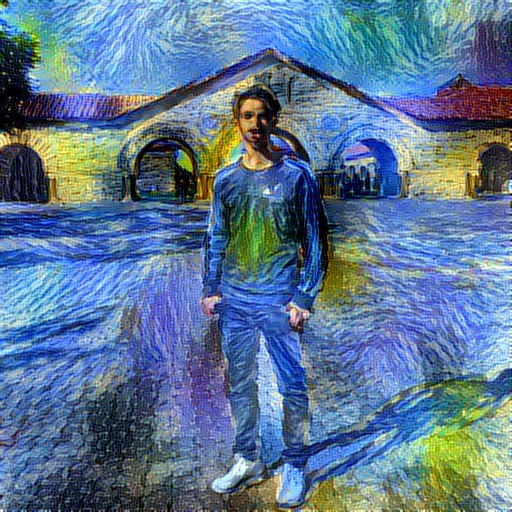

In [17]:
x = x.reshape((height, width, 3))
x = x[:, :, ::-1]
x[:, :, 0] += 103.939
x[:, :, 1] += 116.779
x[:, :, 2] += 123.68
x = np.clip(x, 0, 255).astype('uint8')

Image.fromarray(x)